In [0]:
import torch, torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

https://github.com/pytorch/examples/blob/master/mnist/main.py

In [37]:
transforms = [
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
]
augmentations = [
  #torchvision.transforms.RandomAffine([-90, 90], translate=[0.2, 0.2], scale=[0.5, 0.5], shear=[-10, 10]),
  torchvision.transforms.RandomAffine([-45, 45]),
  torchvision.transforms.RandomAffine([-45, 45], scale=[0.9, 1.1]),
  torchvision.transforms.RandomAffine([0,0], shear=[-45, 45]),
  torchvision.transforms.RandomAffine([-30, 30], scale=[0.9, 1.1], shear=[-45, 45]),
  torchvision.transforms.RandomPerspective(distortion_scale=.5, p=1, interpolation=3)
]
# original untouched
traintransforms = torchvision.transforms.Compose(transforms)
trainset = datasets.MNIST('./data', train=True, download=True, transform=traintransforms)

for augmentation in augmentations:
  traintransforms = torchvision.transforms.Compose([augmentation] + transforms)
  modifiedtrainset = datasets.MNIST('./data', train=True, download=True, transform=traintransforms)
  trainset = torch.utils.data.ConcatDataset([trainset, modifiedtrainset])

print("trainset", trainset.datasets)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testtransforms = torchvision.transforms.Compose(transforms)
testset = datasets.MNIST('./data', train=False, transform=testtransforms)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)
    
#plt.imshow(train_loader.dataset.data[0])
for idx, (data, target) in enumerate(trainloader):
  break
  print("data", data.squeeze().shape)
  plt.imshow(data.squeeze()[0])
  plt.show()
  if idx+1 % 100 == 0: break#print(i)
  continue
  if (train_loader1.dataset.data[i]==train_loader2.dataset.data[i]).sum() != 28**2:
    plt.imshow(train_loader1.dataset.data[0])
    plt.show()
    plt.imshow(train_loader2.dataset.data[0])
    plt.show()

trainset [<torch.utils.data.dataset.ConcatDataset object at 0x7fc7e98dea20>, Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train]


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


net = Net()

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    log_interval = 100
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [42]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/300000 (0%)]	Loss: 2.318762
Train Epoch: 1 [640/300000 (0%)]	Loss: 2.292209
Train Epoch: 1 [1280/300000 (0%)]	Loss: 2.267061
Train Epoch: 1 [1920/300000 (1%)]	Loss: 2.199893
Train Epoch: 1 [2560/300000 (1%)]	Loss: 2.150558
Train Epoch: 1 [3200/300000 (1%)]	Loss: 2.106054
Train Epoch: 1 [3840/300000 (1%)]	Loss: 1.951139
Train Epoch: 1 [4480/300000 (1%)]	Loss: 1.898481
Train Epoch: 1 [5120/300000 (2%)]	Loss: 1.624513
Train Epoch: 1 [5760/300000 (2%)]	Loss: 1.314370
Train Epoch: 1 [6400/300000 (2%)]	Loss: 1.327568
Train Epoch: 1 [7040/300000 (2%)]	Loss: 1.331453
Train Epoch: 1 [7680/300000 (3%)]	Loss: 1.282898
Train Epoch: 1 [8320/300000 (3%)]	Loss: 0.941833
Train Epoch: 1 [8960/300000 (3%)]	Loss: 1.095656
Train Epoch: 1 [9600/300000 (3%)]	Loss: 0.971485
Train Epoch: 1 [10240/300000 (3%)]	Loss: 1.151006
Train Epoch: 1 [10880/300000 (4%)]	Loss: 0.927386
Train Epoch: 1 [11520/300000 (4%)]	Loss: 1.050658
Train Epoch: 1 [12160/300000 (4%)]	Loss: 0.759060
Train Epoch: 1 [1280

In [0]:
torch.save(model.state_dict(),"mnist_cnn.pt")

In [0]:
def see(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            matches = pred.eq(target.view_as(pred)).cpu().numpy().flatten()
            pred = pred.cpu().numpy().flatten()[matches == 0]
            target = target.cpu().numpy().flatten()[matches == 0]
            print("pred", pred.shape)
            print("target", target.shape)
            print("matches", matches.shape, (matches == 0).shape)
            imgs = data.cpu().numpy()[:, 0, :, :][matches == 0]
            print("mismatches", (matches == 0).sum())
            for i, img in enumerate(imgs):
              print(i, "prediction", pred[i], "target", target[i])
              plt.imshow(img)
              plt.show()
            #break
            
            #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.3700%)

pred (3,)
target (3,)
matches (1000,) (1000,)
mismatches 3
0 prediction 7 target 2


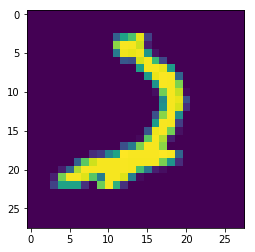

1 prediction 4 target 9


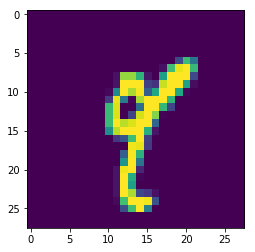

2 prediction 6 target 5


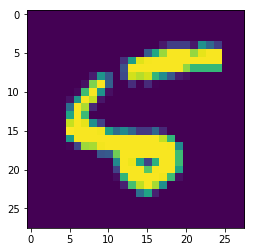

pred (10,)
target (10,)
matches (1000,) (1000,)
mismatches 10
0 prediction 5 target 8


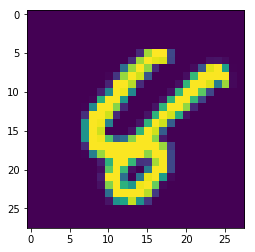

1 prediction 5 target 3


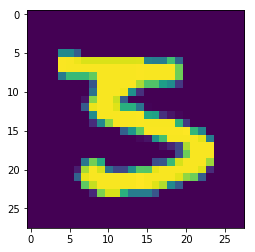

2 prediction 8 target 9


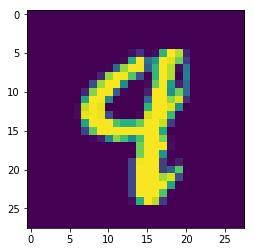

3 prediction 9 target 4


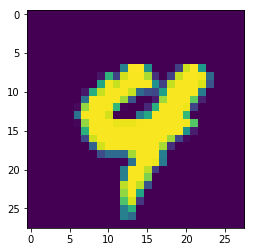

4 prediction 7 target 1


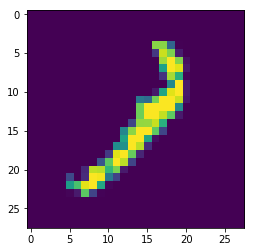

5 prediction 5 target 9


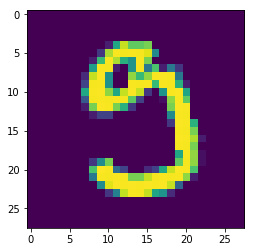

6 prediction 5 target 8


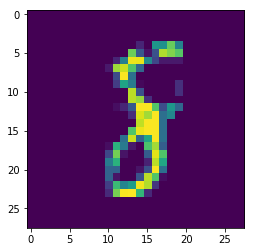

7 prediction 1 target 7


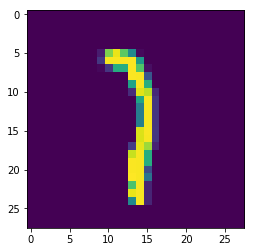

8 prediction 9 target 4


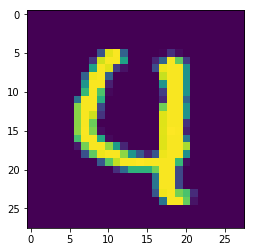

9 prediction 7 target 9


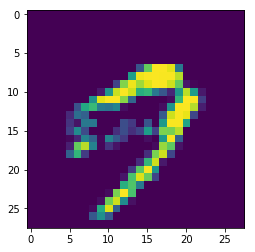

pred (3,)
target (3,)
matches (1000,) (1000,)
mismatches 3
0 prediction 2 target 1


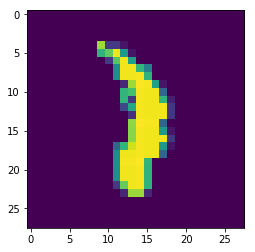

1 prediction 9 target 4


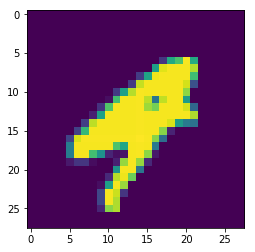

2 prediction 5 target 6


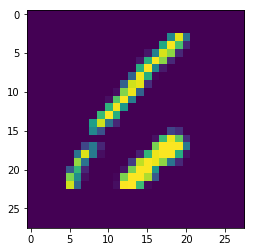

pred (13,)
target (13,)
matches (1000,) (1000,)
mismatches 13
0 prediction 4 target 9


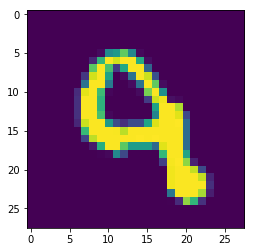

1 prediction 5 target 6


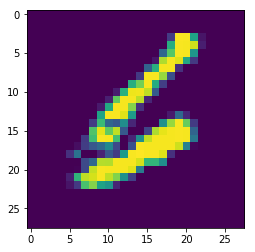

2 prediction 9 target 4


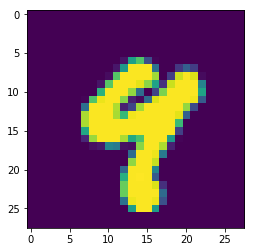

3 prediction 3 target 8


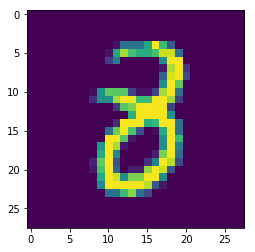

4 prediction 6 target 5


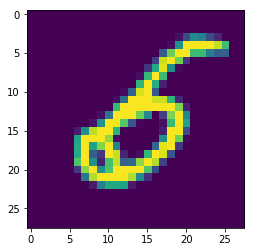

5 prediction 7 target 4


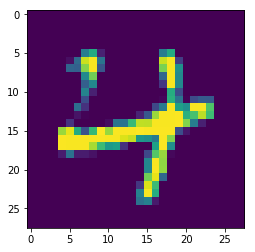

6 prediction 2 target 8


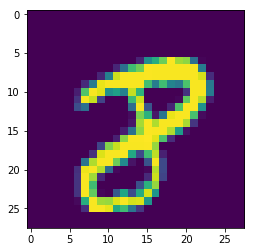

7 prediction 0 target 2


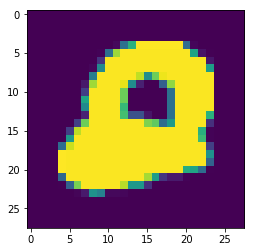

8 prediction 3 target 1


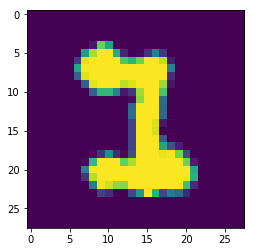

9 prediction 4 target 9


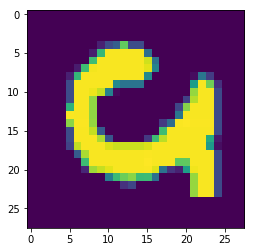

10 prediction 9 target 8


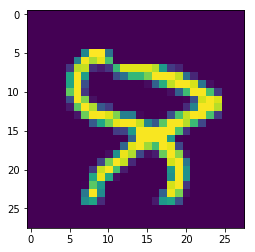

11 prediction 3 target 5


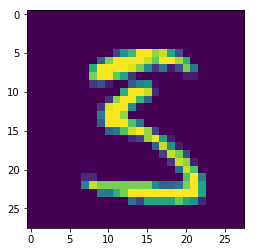

12 prediction 0 target 6


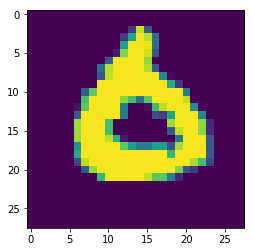

pred (12,)
target (12,)
matches (1000,) (1000,)
mismatches 12
0 prediction 1 target 3


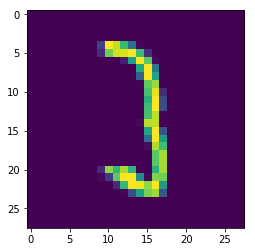

1 prediction 9 target 8


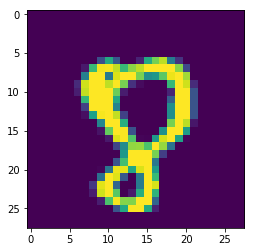

2 prediction 6 target 5


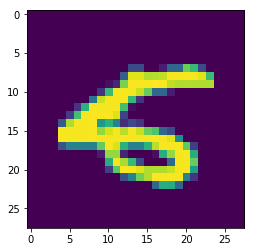

3 prediction 4 target 9


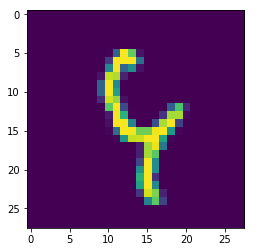

4 prediction 5 target 3


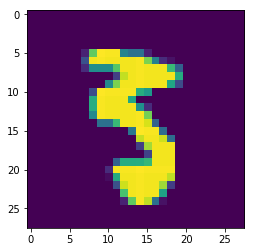

5 prediction 7 target 9


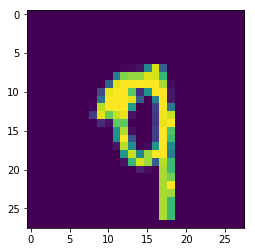

6 prediction 7 target 1


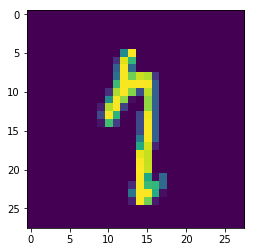

7 prediction 6 target 1


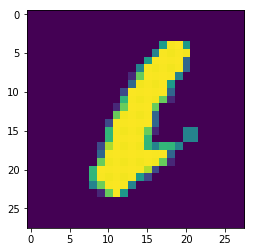

8 prediction 1 target 6


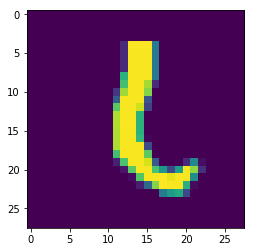

9 prediction 6 target 8


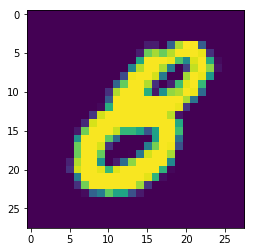

10 prediction 5 target 9


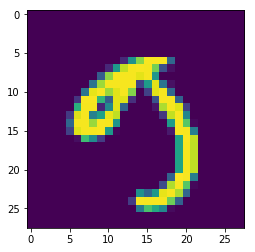

11 prediction 4 target 9


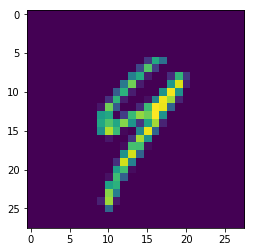

pred (4,)
target (4,)
matches (1000,) (1000,)
mismatches 4
0 prediction 4 target 6


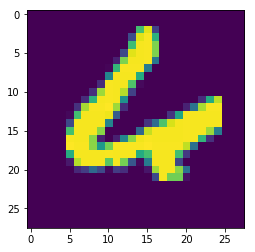

1 prediction 0 target 6


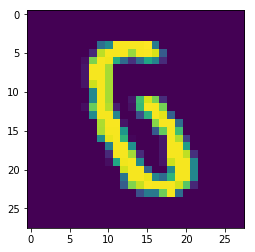

2 prediction 7 target 1


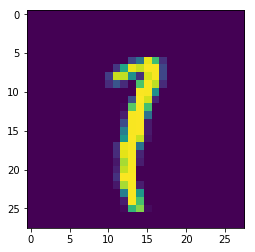

3 prediction 3 target 5


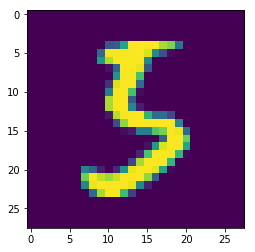

pred (4,)
target (4,)
matches (1000,) (1000,)
mismatches 4
0 prediction 4 target 1


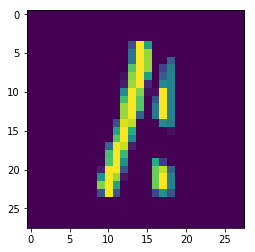

1 prediction 0 target 6


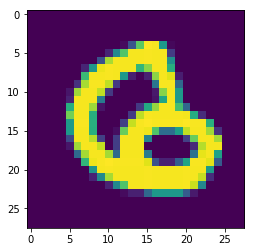

2 prediction 3 target 2


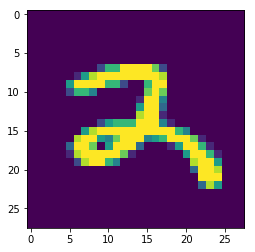

3 prediction 3 target 5


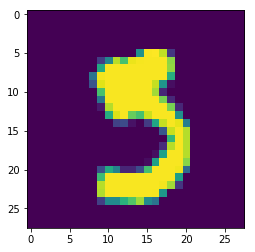

pred (3,)
target (3,)
matches (1000,) (1000,)
mismatches 3
0 prediction 3 target 5


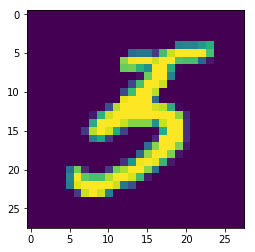

1 prediction 9 target 7


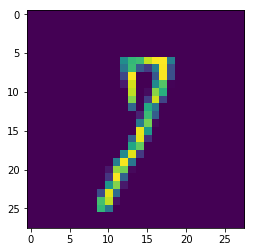

2 prediction 7 target 2


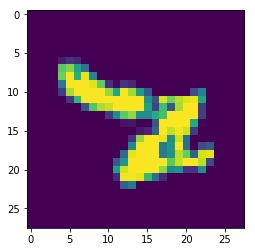

pred (5,)
target (5,)
matches (1000,) (1000,)
mismatches 5
0 prediction 2 target 8


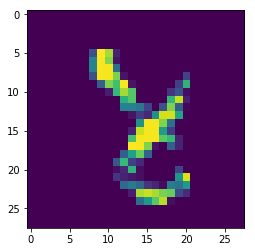

1 prediction 0 target 5


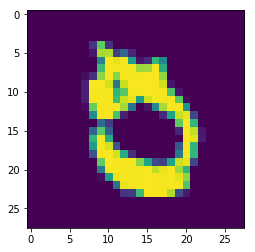

2 prediction 9 target 4


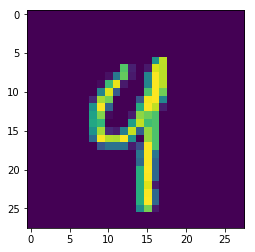

3 prediction 4 target 8


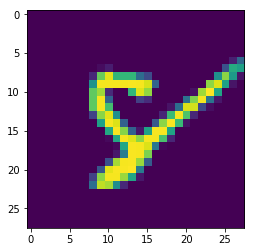

4 prediction 5 target 9


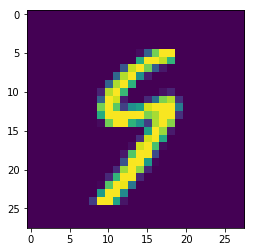

pred (6,)
target (6,)
matches (1000,) (1000,)
mismatches 6
0 prediction 2 target 8


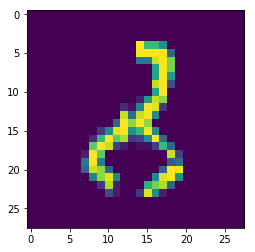

1 prediction 5 target 9


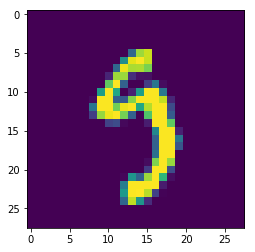

2 prediction 9 target 4


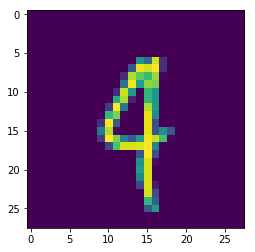

3 prediction 1 target 7


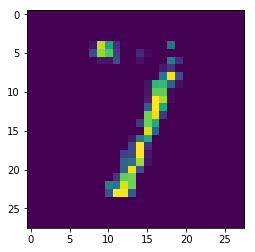

4 prediction 7 target 2


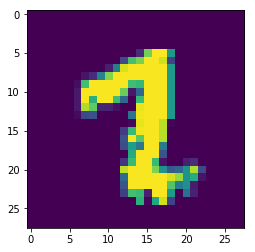

5 prediction 7 target 2


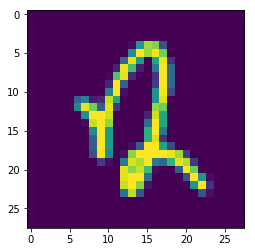

In [47]:
test(model, device, test_loader)
see(model, device, test_loader)